# Up/Down decon with SAG using numpy

In this notebook, we revisit the cost function MDD problem as a finite-sum cost function and we leverage this to solve it by means of minibatch SAG implemented in Numpy.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from stochmdd.mdc import MDC
from stochmdd.stochmdd_numpy import SGD, SAG, ExponentialLR, MDDminibatch, MDDminibatch_repetition
from stochmdd.stochmdd_numpytest import MDDminibatch_consecutive

## Parameters

In [2]:
datapath = '../../data/'

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level

method = 'src_ana'

nsrmax = 201 # max number of sources

## Data loading

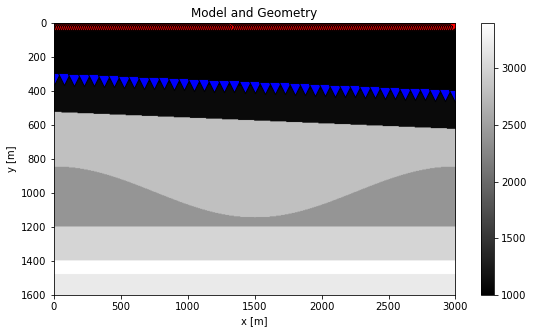

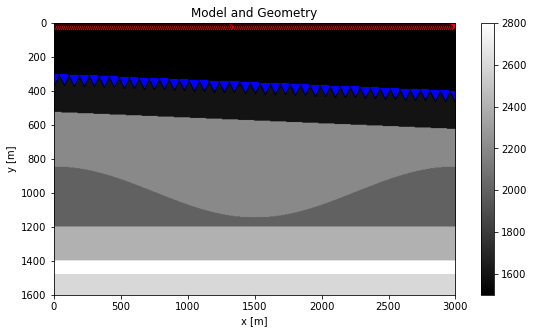

In [3]:
inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')
inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:201+nsrmax]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
s = s[:, :nsrmax]
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

Up/down separated data

In [4]:
data = np.load(os.path.join(datapath, 'updown_dipping_belowseabed_%s.npz'% method))

pup = data['pup'][:nsrmax, :, :nsrmax]
pdown = data['pdown'][:nsrmax, :, :nsrmax]

Reference Reflection response

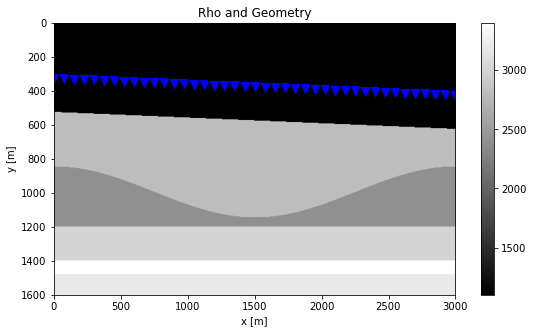

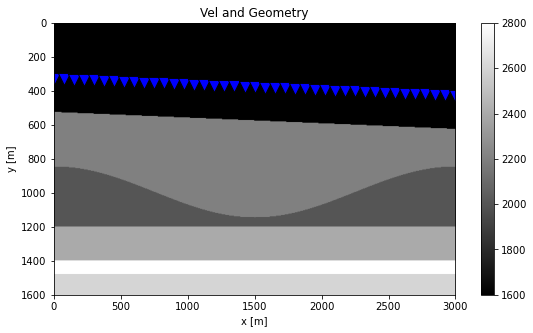

In [5]:
inputfile = os.path.join(datapath, 'input_dipping_noseabed_recsolid.npz')
inputdata = np.load(inputfile)

# data
R = -inputdata['vz_noseabed'][:, :nsrmax]

# Model
rho_ref = inputdata['rho_noseabed']
vel_ref = inputdata['vel_noseabed']

plt.figure(figsize=(9,5))
im = plt.imshow(rho_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Rho and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Vel and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

## Data preparation

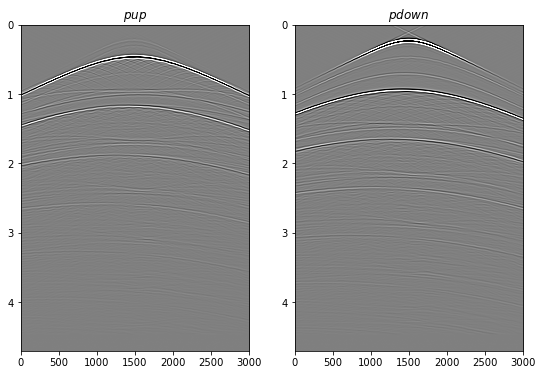

In [6]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50 # 400
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
R = np.pad(R, ((1, npad), (0, 0) ))#.astype('float32')
ntpad = pup.shape[1]
tpad = np.arange(ntpad) * dt
tpad2 = np.hstack((-tpad[::-1], tpad[1:]))


fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

In [7]:
# Rescale data to of amplitude around 1
scaling = 5
pdown *= scaling
pup *= scaling

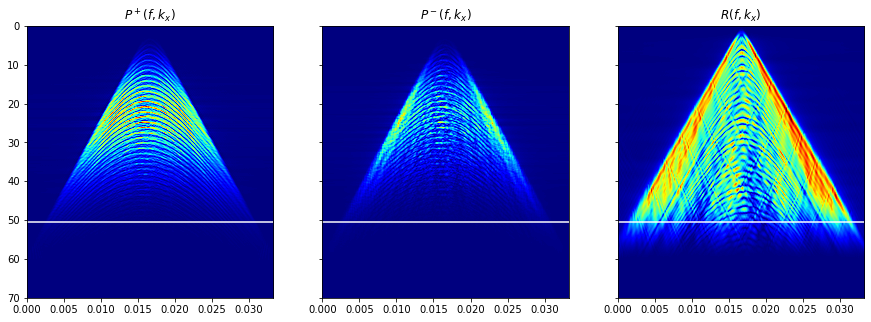

In [8]:
# check max frequency to use
nfmax=250#550
nfft = ntpad#2**11

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)
RTRUE = (FFTop*R.T.ravel()).reshape(nfft, nfft)

# mask away high freqs
mask = np.zeros((nfft, nfft))
mask[:, :nfmax] = 1
mask[:, -nfmax:] = 1
mask = filtfilt(np.ones(50)/50, 1, mask, axis=1)
RTRUE *= mask
R = np.real(FFTop.H * RTRUE.ravel()).reshape(nr, ntpad).T

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(70, 0);

In [9]:
L = 16749.481847268013
print(L)

16749.481847268013


## Stochastic MDD

In [10]:
# Exp 1 (SGD better)
#batch_size = 3
#lr_sgd = .5 / ((batch_size * ntpad)/2)
#lr_sag = 0.2 * ns / (16*L) 
#lr_saga = 0.2 * ns / (16*L) 

# Exp 2 (SGD better)
batch_size = 32
lr_sgd = 8. / ((batch_size * ntpad)/2)
lr_sag = 2. * ns / (16*L) 
lr_saga = .1 * ns / (16*L) 

# Exp 3 (SGD better)
#batch_size = 64
#lr_sgd = 8. / ((batch_size * ntpad)/2)
#lr_sag = 1 * ns / (16*L) 
#lr_saga = 1 * ns / (16*L) 

In [11]:
nepochs = 20
no_of_batches= int(np.ceil(ns/batch_size))
lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
gnormdict = {}
mdict = {}
dr = 1. # force it to 1

In [12]:
pup = pup[:, :, nr//2].T
pdown = np.swapaxes(pdown, 2, 1)

In [13]:
pdown_fft = np.fft.rfft(pdown, ntpad, axis=-1)
pdown_fft = pdown_fft[...,:nfmax]
pdown_fft = pdown_fft.transpose(2,0,1)

MDCop=MDC(pdown_fft, nt=ntpad, nv=1, dt=dt, dr=dr, 
          twosided=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True);

Dot test passed, v^T(Opu)=-1473.270613 - u^T(Op^Tv)=-1473.270613


### Full gradient

In [14]:
lr = 2. / L # must be less than 2/L (2.1 till ok, just round off error of eigenvalue solver)

_ = MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                 nepochs, ns, twosided=False, mtrue=R, seed=0, enormabsscaling=True,
                 epochprint=5, savegradnorm=True,
                 **dict(lr=lr, weight_decay=0))

Initial Loss norm: 1.150490e-02
Initial Gradient norm: 1.415092e-04, scaled by lr: 2.017632e-12
epoch:   5, loss : 1.7165e-03, loss avg : 1.7165e-03
epoch:  10, loss : 8.0403e-04, loss avg : 8.0403e-04
epoch:  15, loss : 5.0692e-04, loss avg : 5.0692e-04
epoch:  20, loss : 3.7267e-04, loss avg : 3.7267e-04
Time: 6.853516 s


### SGD

In [15]:
model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                              nepochs, batch_size, twosided=False, mtrue=R, seed=0, enormabsscaling=True,
                              epochprint=5, savegradnorm=True,
                              **dict(lr=lr_sgd, weight_decay=0))
mdict["SGD"] = model

Initial Loss norm: 1.166678e-02
Initial Gradient norm: 7.742647e-06, scaled by lr: 1.970980e-12
epoch:   5, loss : 1.1986e-04, loss avg : 3.0294e-04
epoch:  10, loss : 3.5520e-05, loss avg : 1.1781e-04
epoch:  15, loss : 2.6050e-05, loss avg : 7.5305e-05
epoch:  20, loss : 1.8061e-05, loss avg : 5.6853e-05
Time: 6.442827 s


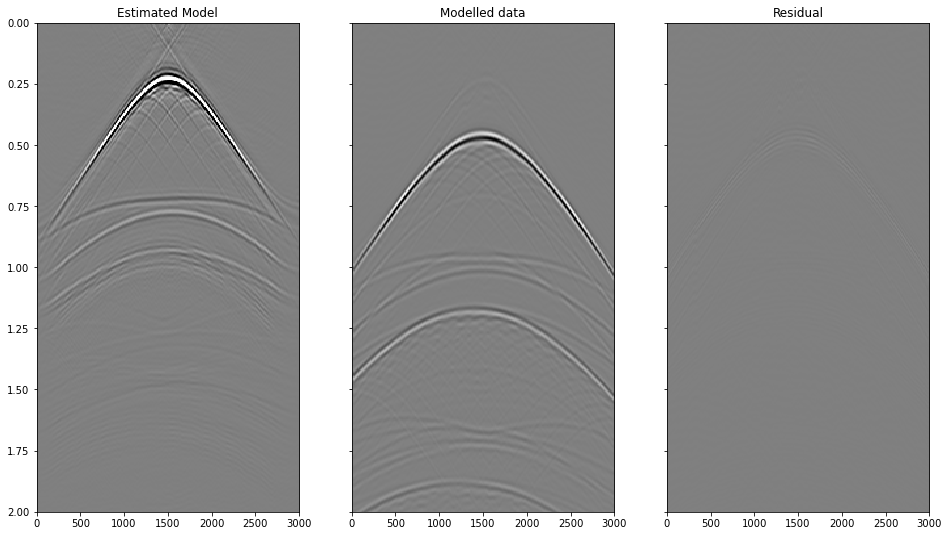

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

### SAG

Step size:

- analytical: ns / (16*L), 
- empirically could go up to ns / L.. ns appears because we divide the gradient by the number of samples

In [31]:
model, dmod, lossdict['SAG'], enormdict['SAG'], _, = \
                 MDDminibatch_repetition(ntpad, nr, dt, dr, pdown_fft, pup, SAG, 
                                         nepochs, batch_size, 
                                         twosided=False, mtrue=R, seed=0, epochprint=5, 
                                         enormabsscaling=True, savegradnorm=True,
                                          **dict(lr=lr_sag, nfuncs=ns, nbatches=int(np.ceil(ns/batch_size)), 
                                                 bs=batch_size, weight_decay=1e-6, saga=False))

mdict["SAG"] = model

Initial Loss norm: 1.166678e-02
Initial Gradient norm: 7.742647e-06, scaled by lr: 1.742203e-11
itr:  35, loss : 3.1013e-03
itr:  70, loss : 1.4378e-03
itr: 105, loss : 9.7966e-04
itr: 140, loss : 7.6706e-04
Time: 6.968451 s


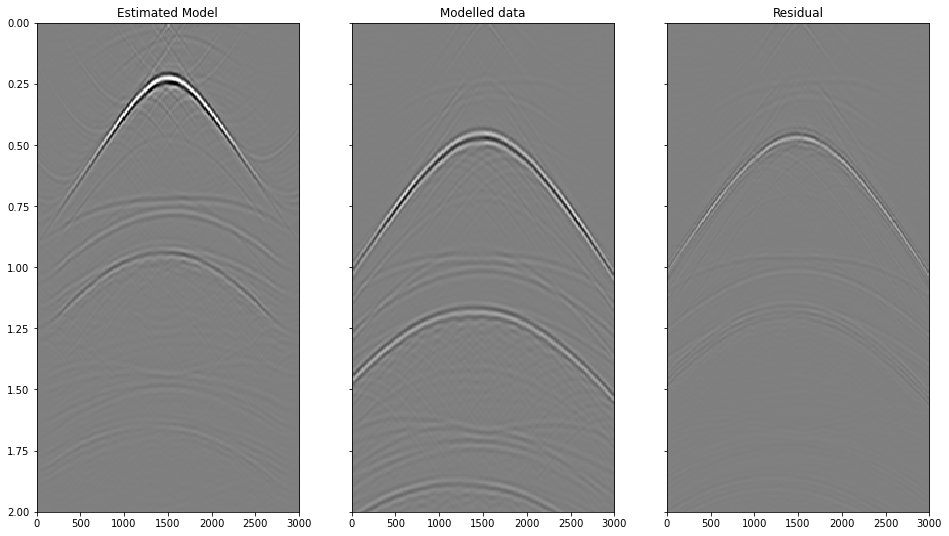

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

### SAGA

In [38]:
model, dmod, lossdict['SAGA'], enormdict['SAGA'], _, = \
                 MDDminibatch_repetition(ntpad, nr, dt, dr, pdown_fft, pup, SAG, 
                                         nepochs, batch_size, 
                                         twosided=False, mtrue=R, seed=0, epochprint=5, 
                                         enormabsscaling=True, savegradnorm=True,
                                          **dict(lr=lr_saga, nfuncs=ns, nbatches=int(np.ceil(ns/batch_size)), 
                                                 bs=batch_size, weight_decay=1e-6, saga=True))

mdict["SAGA"] = model

Initial Loss norm: 1.166678e-02
Initial Gradient norm: 7.742647e-06, scaled by lr: 4.355508e-14
itr:  35, loss : 4.0661e-03
itr:  70, loss : 2.8120e-03
itr: 105, loss : 3.5237e-03
itr: 140, loss : 3.9228e-03
Time: 7.128484 s


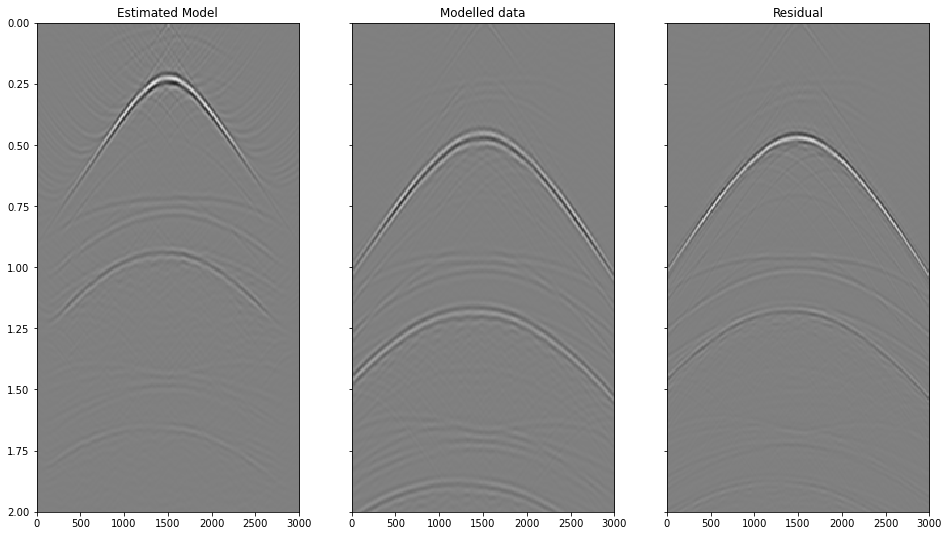

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

## Comparison

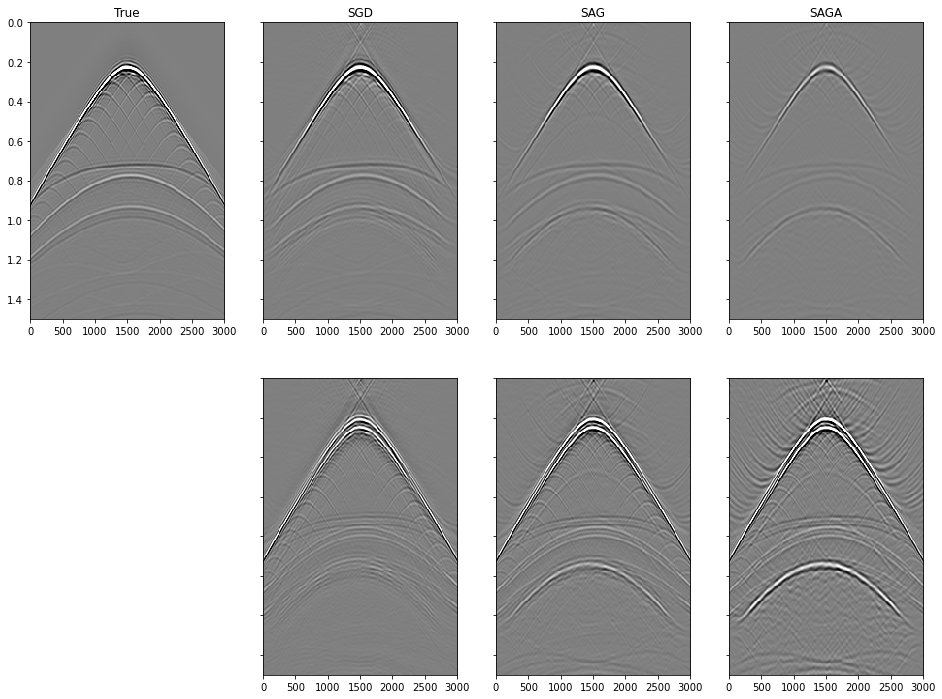

In [40]:
clip = 0.2

fig, axs = plt.subplots(2, len(mdict)+1, sharey=True, figsize=(16, 12))
axs[0][0].imshow(R, aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-clip*R.max(), vmax=clip*R.max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0][0].axis('tight')
axs[0][0].set_title('True')

for iloss, loss in enumerate(mdict.keys()):
    axs[0][iloss+1].imshow(mdict[loss], aspect='auto', interpolation='nearest', cmap='gray',
                           vmin=-clip*R.max(), vmax=clip*R.max(),
                           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
    axs[0][iloss+1].axis('tight')
    axs[0][iloss+1].set_title(loss)
axs[0][-1].set_ylim(1.5, 0)

axs[1][0].axis('off')
for iloss, loss in enumerate(mdict.keys()):
    axs[1][iloss+1].imshow(R/R.max()-mdict[loss]/mdict[loss].max(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-clip, vmax=clip,
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
    axs[1][iloss+1].axis('tight')
axs[1][-1].set_ylim(1.5, 0);

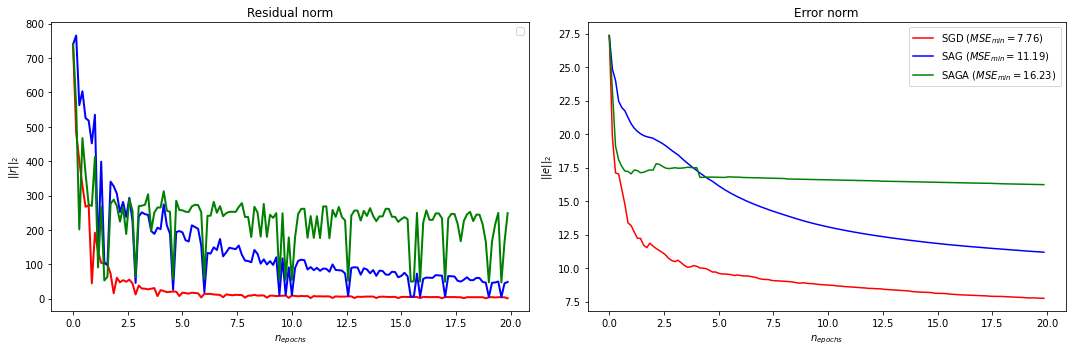

In [41]:
colors = ('r', 'b', 'g')

fig, axs = plt.subplots(1, 2, figsize= (15,5))
for loss, color in zip(lossdict.keys(), colors):
    axs[0].plot(np.arange(len(lossdict[loss]))/no_of_batches, lossdict[loss], 
                '%s' % color, ms=10, linewidth = 2)
axs[0].set_xlabel(r'$n_{epochs}$')
axs[0].set_ylabel(r'$||r||_2$')
axs[0].set_title("Residual norm")
axs[0].legend()

for enorm, color in zip(enormdict.keys(), colors):
    axs[1].plot(np.arange(len(enormdict[enorm]))/no_of_batches, enormdict[enorm], 
                '%s' % color, ms=10, label=r"%s ($MSE_{min}=%.2f)$" % (enorm, np.array(enormdict[enorm]).min()))
    #axs[1].plot((np.arange(len(enormdict[enorm]))/no_of_batches)[::no_of_batches], enormdict[enorm][::no_of_batches],
    #            '.%s' % color, ms=10, linewidth = 2)
axs[1].set_xlabel(r'$n_{epochs}$')
axs[1].set_ylabel(r'$||e||_2$')
axs[1].set_title("Error norm")
axs[1].legend()
fig.tight_layout();